In [1]:
import math


class Tensor:
    def __init__(self, data, _children=(), _op="", requires_grad=True):
        self.data = data  # The scalar or vector value
        self.grad = 0.0  # Gradient wrt
        self._backward = lambda: None  # Function to backpropagate
        self._prev = set(_children)  # Track previous tensors
        self._op = _op  # Operation name (for debugging)
        self.requires_grad = requires_grad  # Flag to track gradients

    def __repr__(self):
        return f"Tensor (data={self.data}, grad={self.grad})"

    def __add__(self, other):
        other = other if isinstance(other, Tensor) else Tensor(other)
        out = Tensor(self.data + other.data, (self, other), "+")

        def _backward():
            if self.requires_grad:
                self.grad += out.grad
            if other.requires_grad:
                other.grad += out.grad

        out._backward = _backward
        return out

    def __radd__(self, other):
        return self + other

    def __neg__(self):
        return self * -1

    def __sub__(self, other):
        return self + (-other)

    def __rsub__(self, other):
        return other + (-self)

    def __mul__(self, other):
        other = other if isinstance(other, Tensor) else Tensor(other)
        out = Tensor(self.data * other.data, (self, other), "*")

        def _backward():
            if self.requires_grad:
                self.grad += other.data * out.grad
            if other.requires_grad:
                other.grad += self.data * out.grad

        out._backward = _backward
        return out

    def __rmul__(self, other):
        return self * other

    def __truediv__(self, other):
        return self * other**-1

    def __pow__(self, power):
        assert isinstance(power, (int, float)), "Only supports int/float powers."
        out = Tensor(self.data**power, (self,), f"**{power}")

        def _backward():
            if self.requires_grad:
                self.grad += (power * self.data ** (power - 1)) * out.grad

        out._backward = _backward
        return out

    def relu(self):
        out = Tensor(self.data if self.data > 0 else 0, (self,), "ReLU")

        def _backward():
            if self.requires_grad:
                self.grad += (out.data > 0) * out.grad

        out._backward = _backward
        return out

    def tanh(self):
        x = self.data
        t = (math.exp(2 * x) - 1) / (math.exp(2 * x) + 1)
        out = Tensor(t, (self,), "tanh")

        def _backward():
            if self.requires_grad:
                self.grad += (1 - t**2) * out.grad

        out._backward = _backward
        return out

    def backward(self):
        topo = []
        visited = set()

        def build_topo(t):
            if t not in visited:
                visited.add(t)
                for child in t._prev:
                    build_topo(child)
                topo.append(t)

        build_topo(self)
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

In [2]:
a = Tensor(2.0)
b = Tensor(3.0)
c = a * b + a**2 - b / a
d = c.relu()
d.backward()

print(f"{a.data}, {a.grad}")
print(f"{b.data}, {b.grad}")
print(f"{d.data}, {d.grad}")

2.0, 7.75
3.0, 1.5
8.5, 1.0


### Building Layers: Neuron, Layer, MLP
*  Neuron : A sing;e fully connected unit : output = wights * inoput + bias
*  Layer : A list of neurond working together on an input vector 
*  MLP : A multi-layer perceptron composed if stacked layers

In [4]:
import random 
from typing import List

class Neuron:
	def __init__(self, nin: int):
		self.w = [Tensor(random.uniform(-1, 1)) for _ in range(nin)]
		self.b = Tensor(0.0)

	def __call__(self, x: List[Tensor]):
		act = sum((wi * xi for wi, xi in zip(self.w, x)), self.b)
		return act.relu() # Using ReLU for hidden layers
	
	def parameters(self):
		return self.w + [self.b]
	
class Layer:
	def __init__(self, nin: int, nout:int):
		self.neurons = [Neuron(nin) for _ in range(nout)]
		
	def __call__(self, x: List[Tensor]):
		out = [n(x) for n in self.neurons]
		return out
	def parameters(self):
		return [p for neuron in self.neurons for p in neuron.parameters()]
	
class MLP:
	def __init__(self, nin: int, nouts: List[int]):
		sz = [nin] + nouts 
		self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

	def __call__(self, x: List[Tensor]):
		for layer in self.layers:
			x = layer(x)
		return x[0] # Single output neuron (regression)
	
	def parameters(self):
		return [p for layer in self.layers for p in layer.parameters()]
	

In [14]:
def mse_loss(predicted, target):

    if isinstance(predicted, Tensor):  # Single output case
        return (predicted - target) * (predicted - target)
    # predicted and target are lists of Tensor
    losses = [(p - t) * (p - t) for p, t in zip(predicted, target)]
    return sum(losses, Tensor(0.0)) * (1/ len(losses))

In [ ]:
# Input vector: 3 features
x = [Tensor(0.5), Tensor(-1.2), Tensor(0.3)]
y_true = [Tensor(1.0)]

# MLP with 1 hidden layers of 4 neurons, 1 output neuron
mlp = MLP(3, [4, 1])

# forward pass
y_pred = mlp(x)

# Compute the loss 
loss = mse_loss([y_pred], y_true)
print("Loss", loss.data)

# backward pass (just for test, assume we want to minimize y )
loss.backward()

# Gradient descent step
learning_rate = 0.01
for p in mlp.parameters():
    p.data -= learning_rate * p.grad
    

Loss 1.0
0


#### Train Loop Example:

In [59]:
for epoch in range(1000):
    y_pred = mlp(x)
    loss = mse_loss([y_pred], y_true)

    # Zero gradients
    for p in mlp.parameters():
        p.grad = 0.0 

    # Backward pass
    loss.backward()

    # Update weights
    for p in mlp.parameters():
        p.data -= learning_rate * p.grad

    if epoch % 100 == 0:
        print(f"Epoch {epoch}: Loss = {loss.data}, Prediction = {y_pred.data}")

Epoch 0: Loss = 2.5249315234344487e-08, Prediction = 0.9998410996688665
Epoch 100: Loss = 4.5590420141436766e-09, Prediction = 0.9999324793215811
Epoch 200: Loss = 8.231406294816827e-10, Prediction = 0.9999713095725113
Epoch 300: Loss = 1.486156267210169e-10, Prediction = 0.9999878091990944
Epoch 400: Loss = 2.683185290802097e-11, Prediction = 0.9999948200528084
Epoch 500: Loss = 4.844344780880429e-12, Prediction = 0.9999977990127713
Epoch 600: Loss = 8.746184972714769e-13, Prediction = 0.9999990647895973
Epoch 700: Loss = 1.5790720404878316e-13, Prediction = 0.9999996026246056
Epoch 800: Loss = 2.8509204074097876e-14, Prediction = 0.9999998311533119
Epoch 900: Loss = 5.147166085700861e-15, Prediction = 0.9999999282562471


In [60]:
# Input and target
x = [Tensor(0.5), Tensor(-1.2), Tensor(0.3)]
y_true = [Tensor(1.0)]

# Initialize model
mlp = MLP(3, [4, 1])
learning_rate = 0.001
losses = []

# Train for 1000 epochs
for epoch in range(1000):
    # Forward pass
    y_pred = mlp(x)
    loss = mse_loss([y_pred], y_true)
    losses.append(loss.data)  # Record loss value

    # Zero gradients
    for p in mlp.parameters():
        p.grad = 0.0

    # Backward pass
    loss.backward()

    # Gradient descent step
    for p in mlp.parameters():
        p.data -= learning_rate * p.grad

    # Optional: print every 100 steps
    if epoch % 100 == 0:
        print(f"Epoch {epoch}: Loss = {loss.data:.4f}, Prediction = {y_pred.data:.4f}")

Epoch 0: Loss = 0.8574, Prediction = 0.0740
Epoch 100: Loss = 0.1957, Prediction = 0.5576
Epoch 200: Loss = 0.0416, Prediction = 0.7961
Epoch 300: Loss = 0.0081, Prediction = 0.9101
Epoch 400: Loss = 0.0015, Prediction = 0.9615
Epoch 500: Loss = 0.0003, Prediction = 0.9837
Epoch 600: Loss = 0.0000, Prediction = 0.9932
Epoch 700: Loss = 0.0000, Prediction = 0.9971
Epoch 800: Loss = 0.0000, Prediction = 0.9988
Epoch 900: Loss = 0.0000, Prediction = 0.9995


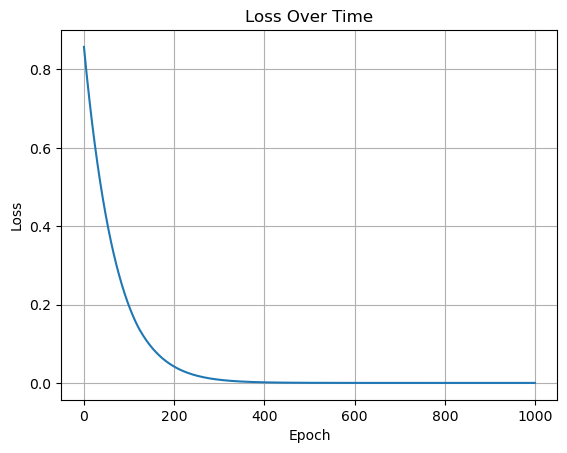

In [61]:
import matplotlib.pyplot as plt

plt.plot(losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Over Time")
plt.grid(True)
plt.show()